In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

In [3]:
from feat_metrics import calculate_n_day_return, calculate_sma, calculate_momentum
from feat_metrics import calculate_volatility, calculate_ema, calculate_capm
from process_modules import TrainModel
from process_modules.load_data import LoadData
from move_data import load_models

# Brazilian stock price prediction

## Section 1: Business Understanding

Predict stocks price or having some type of advantage in market decision is a subject of great interest. However, Efficient Markets Hypothesis says that it is not possible to beat the market because its behaviour is completely random. But a lot of hedge funds have had high gains historically. Can we predict stock prices?

There are two broad categories of approaches used for choose stocks to buy or sell. They are fundamental analysis and technical analysis.
- Fundamental analysis: Look for aspects of a company to try estimate its real value. If the price of this stock is lower than its value buy it and if it is higher than its value sell it.

- Technical analysis: Just use price and volume to discovery patterns and trends to buy or sell a stock.

## Questions
<ol>
 <li>Which variables should we choose for the model?</li>
 <li>Which type of model should we use to performn well in different tickers(stocks)?</li>
 <li>Is model performance good? 
</li>
</ol>

## Section 2: Data Understanding

### Load Datasets

In [4]:
# Function to read from yahooquery API and save it in db
load_data = LoadData('data/Stocks.db')
load_data.load()

In [5]:
# Read data from db in a dataframe
engine = create_engine('sqlite:///data/Stocks.db')
stocks_df = pd.read_sql_table('stocks', engine)

In [6]:
stocks_df.head(3)

,symbol,date,low,close,open,volume,high,adjclose,dividends,splits
0,^BVSP,1993-04-27,24.500000,24.500000,24.799999,0.0,25.400000,24.500000,0.0,0.0
1,^BVSP,1993-04-28,23.700001,24.299999,24.500000,0.0,24.600000,24.299999,0.0,0.0
2,^BVSP,1993-04-29,23.700001,23.700001,24.299999,0.0,24.799999,23.700001,0.0,0.0


In [7]:
#Only some tickers were read from API
stocks_df.symbol.unique().tolist()

['^BVSP',
 'ITSA4',
 'MGLU3',
 'VVAR3',
 'WEGE3',
 'MDIA3',
 'LREN3',
 'ITUB3',
 'EGIE3']

^BVSP is a brazilian stock index of most valued companies. It will be a proxy for market oscilation, similiar of SP500 in EUA.

In [8]:
stocks_df.isnull().sum()

symbol       0
date         0
low          0
close        0
open         0
volume       0
high         0
adjclose     0
dividends    0
splits       0
dtype: int64

No nulls found

In [9]:
stocks_df.dtypes

symbol               object
date         datetime64[ns]
low                 float64
close               float64
open                float64
volume              float64
high                float64
adjclose            float64
dividends           float64
splits              float64
dtype: object

Column types are ok

#### Columns description:

- **symbol**: Ticker of specific stock
- **date**: Reference date
- **close**: Close stock price in reference date
- **high**: The highest stock price achived in reference date
- **open**: Open stock price in reference date
- **low**: The lowest stock price achived in reference date
- **volume**: Volume of transactions of specific ticker in reference date 
- **adjclose**: Close stock price in reference date adjusted historically when events happened such as dividends, splits and price modificators.
- **dividends**: Divideds payed per unit in reference date
- **splits**: Modificator ratio in number of papers in reference date. Ex.: 10 units became 11, if splits were 1.1.

For this project only symbol, date and adjclose were used. The first approach to tackle this problem is through technical analysis.

## Section 3: Prepare Data

For this analysis was arbitraty choosen:
- Period of 01/Aug/2020 to 30/Nov/2020.
- Tickers: ITSA4 - Itau holding(biggest private bank in Latin America), MGLU3 - Magazine Luiza (one of the biggest retail company in Brazil) and EGIE3 - private company in energy sector.
- Targets options: predict next day, next week, next 2 weeks and next month of data used to train.

Obs. dataset has only days which market opened, so the approximation for 1 month is to read next 22 datapoints (workdays).

- Forecast date: A ground date to be used to predict next n days according to the target option. Ex:. forecast_date set to 2020-12-21 and target set to 1_day, the prediction will be to 2020-12-22. If for the same target option forecast_date is set to 2020-12-11, the prediction will be for 2020-12-14 (next workday). 

In [10]:
start_date = pd.to_datetime('2020-08-01')
end_date = pd.to_datetime('2020-11-30')
train_range_days = (end_date - start_date).days

symbols = ['ITSA4', 'MGLU3', 'EGIE3']

targets_dict = {'1_day': 1,
                '1_week': 5,
                '2_weeks': 10,
                '1_month': 22}

forecast_date = pd.to_datetime('2020-12-21')

# path to save pickle models
models_path = 'models/models.pkl'

In [11]:
# TrainModel is a class to prep features and run entire pipeline model 
train_model = TrainModel(stocks_df, symbols, start_date, end_date, models_path, targets_dict)

In [12]:
# Prepare a dataframe with features
itsa4, ibov = TrainModel.prep_historical_data(stocks_df, 'ITSA4', start_date, end_date)

prep_historical_date gets all days between start_date and end_date more 180 workdays before and 45 workdays after this period. These delta days are used to be possible calculate a future target date to evaluation and a big past window for features. 

#### Q1 - Which variables should we choose for the model?

Based on course "Machine Learning for Trading", Tucker Balch (Georgia Tech and Udacity)
Some technical indicators were created as features.

It was analyzed some indicator for ITSA4 ticker.

#### Daily return

In [13]:
itsa4_daily_return = calculate_n_day_return(itsa4)

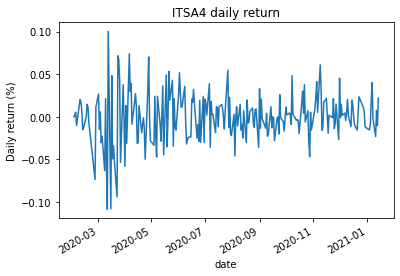

In [14]:
ax = itsa4_daily_return.plot()
ax.set_title("ITSA4 daily return")
_ = ax.set_ylabel("Daily return (%)")

#### CAPM

CAPM equations: $stockprice = \beta * marketprice + \alpha$

Beta is an indicator which decribes how a specific stock is correlated with the market.
Alpha is an offset between stockprice and market after beta variation, it usually is zero.

In [15]:
capm_df = calculate_capm(itsa4, ibov, window=30)

In [16]:
beta = capm_df.loc[forecast_date].beta

In [17]:
print(f'Beta for data reference {forecast_date}, using 30 points to calculate line coefs is {round(beta, 2)}')

Beta for data reference 2020-12-21 00:00:00, using 30 points to calculate line coefs is 0.55


Beta is 0.55. Therefore, if ibovespa index (good proxy for brazilian market increases 100% tomorrow, ITSA4 will increases 55%).

#### Simple Moving Average (SMA)

SMA is mean average of adjclose price looking a window of days

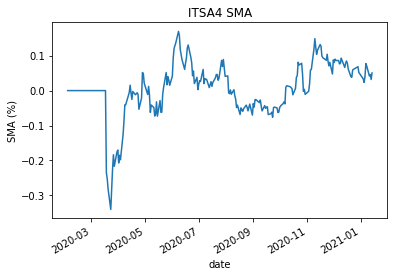

In [18]:
ax = calculate_sma(itsa4, window=30).plot()
ax.set_title("ITSA4 SMA")
_ = ax.set_ylabel("SMA (%)")

How larger the window, more smooth the series becomes. There is not all 30 point to calculate average in the oldest days, it is the reason this curve is flat in the beginning. However, aditional 180 days before was included in this series to be cut after features creation. 

#### Exponential Moving Average (EMA)

EMA is similar to SMA, but recent dates have more weight than old dates in the window.

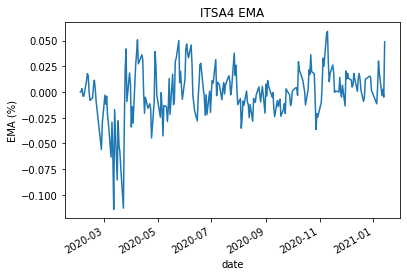

In [19]:
ax = calculate_ema(itsa4, window=30).plot()
ax.set_title("ITSA4 EMA")
_ = ax.set_ylabel("EMA (%)")

Same consideration of SMA, but it gets faster variations in price.

#### Momentum

Momentum is the ratio of forecast_price and some day before. It gives a feeling of price's direction trend. 

In [20]:
round(calculate_momentum(itsa4, window=7).loc[forecast_date], 2)

-0.01

In forecast_date momentum indicates no moving in prices.

#### Volatility

Volatility is standard deviation in a window. In stock market, this is associated with risk. How more volatile the market, greater the risk

calculate_volatility(itsa4, window=30).plot()
ax.set_title("ITSA4 Volatility")
_ = ax.set_ylabel("Volatility")

In this plot is possible to observe market response with high oscilation due to beginning of Covid-19's quarantine in Brazil (end of march 2020).

#### Variables dataframe

In [21]:
# Encapsulate function to create features dataframe and drop aditional period apart from start and end date range
itsa4_vars_df = TrainModel.prep_modeling_data(itsa4, ibov, targets_dict, start_date, end_date, True)

In [22]:
itsa4_vars_df.head()

,sma_ITSA4_7,sma_ITSA4_14,sma_ITSA4_36,sma_ITSA4_73,sma_ITSA4_146,sma_momentum_7,sma_momentum_36,sma_momentum_73,sma_^BVSP_73,volatility_^BVSP,...,ema_ITSA4_7,ema_ITSA4_14,ema_ITSA4_36,ema_ITSA4_73,ema_ITSA4_146,ITSA4,target_1_day,target_1_week,target_2_weeks,target_1_month
date,,,,,,,,,,,,,,,,,,,,,
2020-08-03,-0.011352,0.010251,0.046369,0.115538,0.0,0.121951,2.642979,-7.213103,0.123375,9262.239827,...,-0.008416,-0.006497,-0.006295,-0.006295,-0.006295,10.499140,10.018339,10.165523,9.449225,9.469027
2020-08-04,-0.053628,-0.035623,-0.003308,0.062541,0.0,-0.335315,0.981540,-5.031986,0.102074,9208.903455,...,-0.036086,-0.035267,-0.035141,-0.035141,-0.035141,10.018339,10.008525,10.008525,9.636048,9.666503
2020-08-05,-0.044177,-0.036892,-0.005471,0.059596,0.0,-0.303025,0.846613,-5.408202,0.115663,9200.616996,...,-0.023409,-0.024442,-0.024350,-0.024350,-0.024350,10.008525,10.126274,9.920216,9.567217,9.646756
2020-08-06,-0.025627,-0.025890,0.005168,0.069779,0.0,-0.175943,0.989120,-6.780680,0.125939,9185.385496,...,-0.006870,-0.008686,-0.008618,-0.008618,-0.008618,10.126274,10.018339,9.674907,9.508223,9.518396
2020-08-07,-0.023900,-0.034906,-0.005439,0.055634,0.0,-0.074646,0.975432,-8.300813,0.106841,9034.175204,...,-0.009878,-0.012895,-0.012872,-0.012872,-0.012872,10.018339,10.165523,9.743596,9.567217,9.557892


To create vars_df were choosen some windows for each indicator based in practical found in:

    - https://www.investopedia.com/terms/s/sma.asp
    - https://www.investopedia.com/terms/e/ema.asp

Obs. consecutive days transformed to work days.

Other windows are created arbitrarily.

Some indicator were combined. 

Example: sma_momentum_36 - it is SMA of momentum series with windows 36 work days before forecast_date.

Ticker (ITSA) feature is the last price that we have information for prediction.

In this function predefined targets were calculated for next day, next week, next 2 weeks and next month based on end_date.

## Section 4: Data Modeling

- Linear Regression

In [23]:
lr = LinearRegression()
pipeline_lr = make_pipeline(StandardScaler(), lr)

Simple linear model to have a baseline

- Random Forest

In [24]:
rf = RandomForestRegressor(random_state=0, n_estimators=1000)
pipeline_rf = make_pipeline(StandardScaler(), rf)

Random Forest approach with not many estimatores. It was tested manually parameters changed, MAE does not decrease if it is increased the number of estimators.

- Neural Net

In [25]:
neural_net = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam',
                           random_state=0, alpha=10, learning_rate='constant', max_iter=10**5,
                           shuffle=False, early_stopping=True)
pipeline_neuralnet = make_pipeline(StandardScaler(), neural_net)

Neural net with a small architecture, some variations were tested manually. If it is increased network architecture, it starts to overfit.

In [26]:
# encapsulating pipelines
pipelines = {'lr': pipeline_lr,
             'rf': pipeline_rf,
             'neural_net': pipeline_neuralnet}

## Section 5: Evaluation

#### Q2 - Which type of model should we use to performn well in different tickers(stocks)?

#### ITSA4

In [27]:
TrainModel.calculate_results(itsa4_vars_df, targets_dict, pipelines)

target,1_day,1_week,2_weeks,1_month
lr,0.710812,2.96192,1.48595,1.79119
rf,0.735571,1.42158,1.2544,1.54622
neural_net,0.509756,1.22557,1.06636,0.706233


For ITSA4 both models were similar, neural net showed a better performance and linear regression a lower overall performance.

#### MGLU3

In [28]:
# Calculate features for MGLU3 in same period
mglu3, ibov = TrainModel.prep_historical_data(stocks_df, 'MGLU3', start_date, end_date)
vars_mglu3_df = TrainModel.prep_modeling_data(mglu3, ibov, targets_dict, start_date, end_date, True)

In [29]:
TrainModel.calculate_results(vars_mglu3_df, targets_dict, pipelines)

target,1_day,1_week,2_weeks,1_month
lr,25.2759,24.5517,24.3108,6.28074
rf,0.70692,1.20809,0.920421,0.615184
neural_net,1.93093,1.58102,1.60405,1.8777


For MGLU3, linear regression did not work well, and random forest were better than neural net.

#### EGIE3

In [30]:
# Calculate features for EGIE3 in same period
egie3, ibov = TrainModel.prep_historical_data(stocks_df, 'EGIE3', start_date, end_date)
vars_egie3_df = TrainModel.prep_modeling_data(egie3, ibov, targets_dict, start_date, end_date, True)

In [31]:
TrainModel.calculate_results(vars_egie3_df, targets_dict, pipelines)

target,1_day,1_week,2_weeks,1_month
lr,1.69305,10.1717,5.58798,6.81806
rf,1.06831,0.629994,0.935271,2.27706
neural_net,13.6179,13.6655,13.4215,14.3928


For EGIE3, linear regression and neural net overfit. Random forest keeps a good performance.

For these results, random forest pipeline was choosen. It performs better in a generic way.

#### Q3 - Is model performance good? 

In [32]:
start_date_test = end_date + pd.DateOffset(days=1)
end_date_test = stocks_df.date.max() - pd.DateOffset(days=35)

In [33]:
print(f'In test set: \nstart_date is {start_date_test.strftime("%Y-%m-%d")}')
print(f'test_date is {end_date_test.strftime("%Y-%m-%d")}')

In test set: 
start_date is 2020-12-01
test_date is 2021-01-05


In [34]:
# Train model for all symbols and targets config params (Random Forest used)
train_model.create_models()

In [35]:
# Load pickle models
models = load_models(models_path)

In [36]:
# Create dataframe with features and targets in test period for ITSA4
itsa4_test, ibov_test = TrainModel.prep_historical_data(stocks_df, 'ITSA4', start_date_test, end_date_test)
vars_itsa4_test_df = TrainModel.prep_modeling_data(itsa4_test, ibov_test, targets_dict, start_date_test, end_date_test, True)

In [37]:
def plot_test_result(target_period, models, symbol, vars_test_df):
    ''' Load a specif trained model for a specific target period, predict values
    using vars dataframe and create a plot comparation between true and predict value.
    
    params:
    target_period (string): Target name according targets_dict sintax. 
        Ex.: '1_day' is the target to predict next day, '1_week' to next week.
    models (dict): All models fit for all possible targets and a list of symbols.
    symbol (string): Ticker name to plot the result.
    vars_test_df (dataframe): Dataframe with all features and targets ready to use in
        desireble period.
    returns:
    ax (plot): Plot comparation between true and predict value 
    
    '''
    # Load specific model
    model = models[symbol][target_period]['model']

    X = vars_test_df.filter(regex='^(?!target_)')
    y = vars_test_df['target_' + target_period].copy()
    
    # Predict next prices
    y_pred = model.predict(X)
    
    # Merge true and pred value
    y_pred = pd.DataFrame(zip(y_pred, X.index), columns=['y_pred', 'date'])
    y_pred.set_index('date', inplace=True)
    result = pd.concat([y_pred.y_pred, y], axis=1)

    # Create plot result
    ax = result.y_pred.plot()
    ax = result['target_' + target_period].plot()
    ax.set_title(symbol + ' - ' + 'target ' + target_period)
    ax.set_ylabel("Price (R$)")
    ax.legend()

    return ax

#### Results for ITSA4

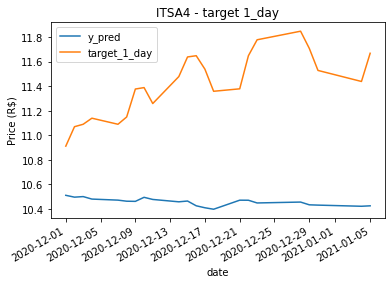

In [38]:
# Plot result for next day prediction
ax = plot_test_result('1_day', models, 'ITSA4', vars_itsa4_test_df)

This model only keeps price in a safe mean.

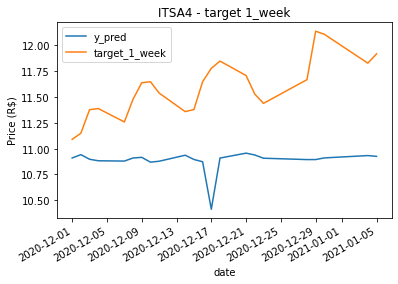

In [39]:
# Plot result for next week prediction
ax = plot_test_result('1_week', models, 'ITSA4', vars_itsa4_test_df)

This model only tried to forecast price decay, but it started to increase.

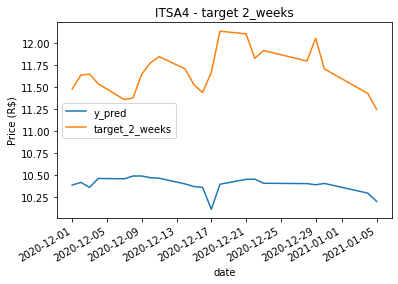

In [40]:
# Plot result for next 2 weeks prediction
ax = plot_test_result('2_weeks', models, 'ITSA4', vars_itsa4_test_df)

Same pattern of last plot, but a bit more smoothed.

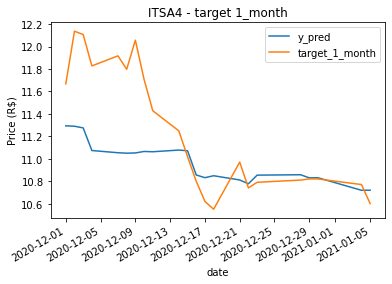

In [41]:
# Plot result for next month prediction
ax = plot_test_result('1_month', models, 'ITSA4', vars_itsa4_test_df)

This model only keeps price prediction in a safe range. It changes a little bit after real prices changes a lot.

#### Results for MGLU3

In [42]:
mglu3_test, ibov_test = TrainModel.prep_historical_data(stocks_df, 'MGLU3', start_date_test, end_date_test)
vars_mglu3_test_df = TrainModel.prep_modeling_data(mglu3_test, ibov_test, targets_dict, start_date_test, end_date_test, True)

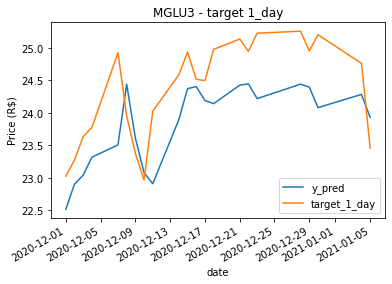

In [43]:
# Plot result for next day prediction
ax = plot_test_result('1_day', models, 'MGLU3', vars_mglu3_test_df)

This model is just copying past price behaviour.

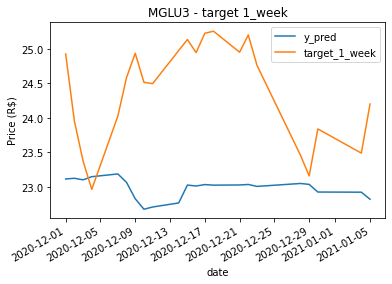

In [44]:
# Plot result for next week prediction
ax = plot_test_result('1_week', models, 'MGLU3', vars_mglu3_test_df)

This model keeps price prediction in a safe mean.

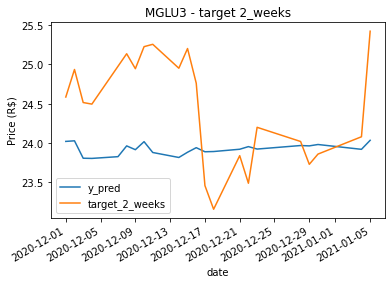

In [45]:
# Plot result for next 2 weeks prediction
ax = plot_test_result('2_weeks', models, 'MGLU3', vars_mglu3_test_df)

This plot shows a "safe mean" model too.

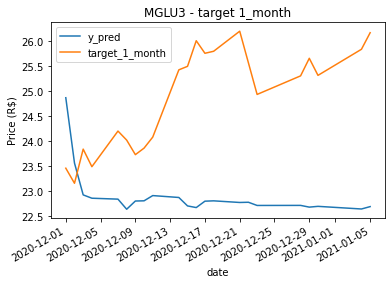

In [46]:
# Plot result for next month prediction
ax = plot_test_result('1_month', models, 'MGLU3', vars_mglu3_test_df)

It is a bit strange the first predictions, but it keeps price in a safe mean too.

#### Results for EGIE3

In [47]:
egie3_test, ibov_test = TrainModel.prep_historical_data(stocks_df, 'EGIE3', start_date_test, end_date_test)
vars_egie3_test_df = TrainModel.prep_modeling_data(egie3_test, ibov_test, targets_dict, start_date_test, end_date_test, True)

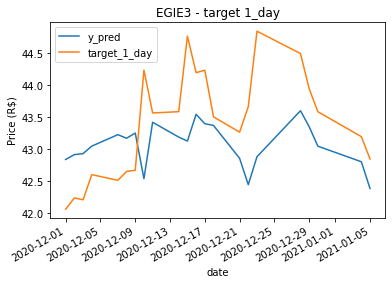

In [48]:
# Plot result for next day prediction
ax = plot_test_result('1_day', models, 'EGIE3', vars_egie3_test_df)

This model is only copying the past price behaviour.

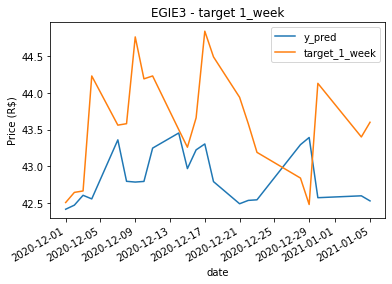

In [49]:
# Plot result for next week prediction
ax = plot_test_result('1_week', models, 'EGIE3', vars_egie3_test_df)

This model tries to make a real prediction. It is possible to see in last great orange peak, the model predicts the fall of prices and both lines intersect each other.

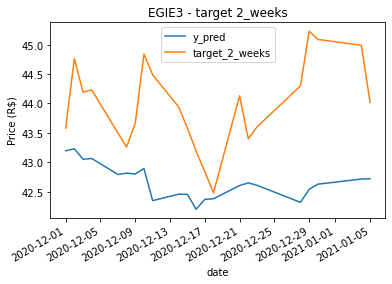

In [50]:
# Plot result for next 2 weeks prediction
ax = plot_test_result('2_weeks', models, 'EGIE3', vars_egie3_test_df)

Similar to last plot, but a bit more smoothed.

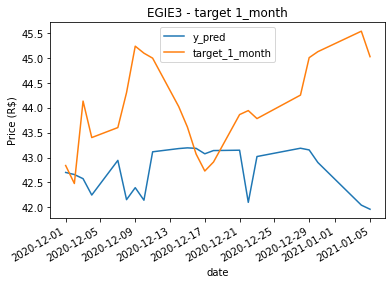

In [51]:
# Plot result for next month prediction
ax = plot_test_result('1_month', models, 'EGIE3', vars_egie3_test_df)

This model tries to predict tendences, but it is not so accurate.

### Conclusion

It was possible to explore a lot of market metrics and test different models setups. However, predict stock prices is a big challenge, stock prices patterns changes too fast. In results was possible to observe 3 models behaviours:
- Only keep safe in a mean price to not get a big error
- Copy past behaviour but nothing is new
- Try to predict some trend, but probably get wrong.

The last model type is the most interesting, it need to be improved but it is a good start.

It is possible to test in future works:
- Other metric instead of MAE to check if the model takes more choices
- Use new features based in Fundamental analysis and apply text mining in social media to try to catch market trends
- Test new types of models, specific to time series.